In [3]:
!pip install -Uqq fastai

In [4]:
from fastai.tabular.all import*
from fastai.collab import *
path = untar_data(URLs.ML_100k)

In [5]:
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/u2.test'),Path('/root/.fastai/data/ml-100k/u1.test'),Path('/root/.fastai/data/ml-100k/u.item'),Path('/root/.fastai/data/ml-100k/u3.base'),Path('/root/.fastai/data/ml-100k/README'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/u.occupation'),Path('/root/.fastai/data/ml-100k/u.info'),Path('/root/.fastai/data/ml-100k/u1.base')...]

In [7]:
readme = open(path/'README','r')
print(readme.read())

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [8]:
ratings = pd.read_csv(path/'u.data', 
                 delimiter='\t',
                 header=None,
                 names=['user','movie','rating','timestamp']
                )
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
movies = pd.read_csv(path/'u.item',
                    delimiter='|',
                    encoding='latin-1',
                    usecols=(0,1),
                    names=('movie','title'),
                    header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [12]:
ratings = ratings.merge(movies,on='movie')

In [13]:
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


# CollabDataLoaders takes by default  

first coloumn -> USER ID  
second coloumn -> Movie or ITEM  
thrid coloumn -> RATINGS  

In [14]:
dls = CollabDataLoaders.from_df(ratings,
                                user_name='user',
                                item_name='title',
                                rating_name='rating'
                               )
dls.show_batch()

,user,title,rating
0,64,"Sting, The (1973)",5
1,628,In & Out (1997),4
2,788,"Specialist, The (1994)",3
3,229,L.A. Confidential (1997),5
4,425,Tank Girl (1995),1
5,346,Sleepless in Seattle (1993),4
6,763,Dances with Wolves (1990),3
7,487,Field of Dreams (1989),4
8,711,Great Expectations (1998),3
9,604,Psycho (1960),2


In [16]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [18]:
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

In [30]:
sigmoid_range(user_factors[0]@movie_factors[0].T,-1,1)*5.5

tensor(4.2120)

In [26]:
user_factors[3]

tensor([-1.3474,  0.1577, -0.4202,  0.4398,  1.0361])

In [31]:
k=one_hot(3,n_users).float()

In [32]:
k.shape

torch.Size([944])

In [48]:
k@user_factors == user_factors[3]

tensor([True, True, True, True, True])

In [77]:
class DotProduct(Module):
    
    def __init__(self,n_users,n_movies,n_factors):
        self.user_factors = Embedding(n_users,n_factors)
        self.movie_factors = Embedding(n_movies,n_factors)
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users*movies).sum(dim=1)

In [60]:
x,y = dls.one_batch()

In [74]:
user_factors[x[0,0]]@movie_factors[x[0,1]]

tensor(2.0012)

In [84]:
model = DotProduct(n_users,n_movies,50)
learn = Learner(dls,model,loss_func=MSELossFlat())

In [85]:
learn.fit_one_cycle(5,0.003)

epoch,train_loss,valid_loss,time
0,1.009223,1.004953,00:09
1,0.889517,0.910782,00:09
2,0.764285,0.858140,00:09
3,0.691234,0.838292,00:09
4,0.606075,0.837588,00:09


In [86]:
learn.fit_one_cycle(5,0.001)

epoch,train_loss,valid_loss,time
0,0.593781,0.839074,00:09
1,0.554186,0.840344,00:09
2,0.524977,0.845222,00:09
3,0.468125,0.848962,00:09
4,0.423036,0.849688,00:09


SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=1.9054607491852948e-06)

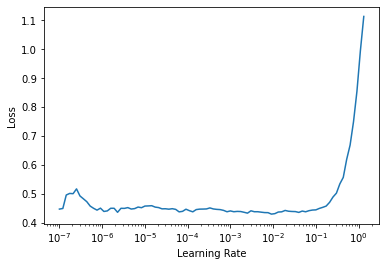

In [87]:
learn.lr_find()

In [90]:
learn.fit_one_cycle(5,2e-6)

epoch,train_loss,valid_loss,time
0,0.428413,0.849699,00:09
1,0.426200,0.849726,00:09
2,0.430084,0.849748,00:09
3,0.412100,0.849758,00:09
4,0.407724,0.849760,00:09


In [83]:
class DotProduct(Module):
    
    def __init__(self,n_users,n_movies,n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users,n_factors)
        self.movie_factors = Embedding(n_movies,n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users*movies).sum(dim=1),*self.y_range)

In [91]:
class DotProduct(Module):
    
    def __init__(self,n_users,n_movies,n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users,n_factors)
        self.user_bias = Embedding(n_users,1)
        self.movie_factors = Embedding(n_movies,n_factors)
        self.movie_bias = Embedding(n_movies,1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        result = (users*movies).sum(dim=1,keepdim=True)
        result += self.user_bias(x[:,0])+self.movie_bias(x[:,1])
        return sigmoid_range(result, *self.y_range)


In [92]:
model = DotProduct(n_users,n_movies,50)
learn = Learner(dls,model,loss_func=MSELossFlat())

In [93]:
learn.fit_one_cycle(5,0.003)

epoch,train_loss,valid_loss,time
0,0.965068,0.950033,00:11
1,0.809456,0.851785,00:10
2,0.708739,0.823005,00:10
3,0.592424,0.820241,00:10
4,0.494817,0.821856,00:10


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=6.309573450380412e-07)

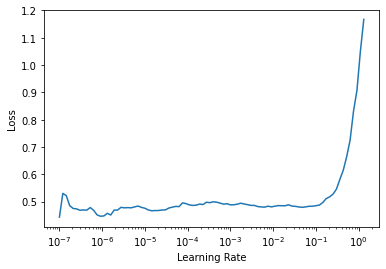

In [94]:
learn.lr_find()

In [95]:
learn.fit_one_cycle(5,0.00003)

epoch,train_loss,valid_loss,time
0,0.492637,0.821921,00:11
1,0.498733,0.822159,00:10
2,0.495647,0.822344,00:10
3,0.484676,0.822411,00:10
4,0.478634,0.822416,00:10


In [96]:
model = DotProduct(n_users,n_movies,50)
learn = Learner(dls,model,loss_func=MSELossFlat())
learn.fit_one_cycle(5,0.003,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.964189,0.951501,00:10
1,0.874562,0.872645,00:11
2,0.772654,0.832125,00:10
3,0.683918,0.815148,00:11
4,0.632606,0.814004,00:11


In [97]:
learn.fit_one_cycle(5,0.003,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.651666,0.833075,00:10
1,0.673342,0.829541,00:10
2,0.559676,0.827271,00:11
3,0.465956,0.828456,00:11
4,0.396449,0.829959,00:10


In [129]:
movie_bias = learn.model.movie_bias.weight.squeeze()
movie_bias


tensor([ 0.0018, -0.1537, -0.0668,  ..., -0.0823,  0.0770,  0.0212],
       grad_fn=<SqueezeBackward0>)

In [133]:
idxs = movie_bias.argsort(descending=True)[:5]
idxs
[dls.classes['title'][i] for i in idxs]

["Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'As Good As It Gets (1997)',
 'Good Will Hunting (1997)',
 'L.A. Confidential (1997)']

In [134]:
movie_factors = learn.model.movie_factors.weight
idxs = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors,movie_factors[idxs][None])
idxs = distances.argsort(descending=True)[:5]
[dls.classes['title'][idx] for idx in idxs]

['Silence of the Lambs, The (1991)',
 'Pather Panchali (1955)',
 'Walk in the Sun, A (1945)',
 'New York Cop (1996)',
 'Rebecca (1940)']

In [135]:
%matplotlib inline

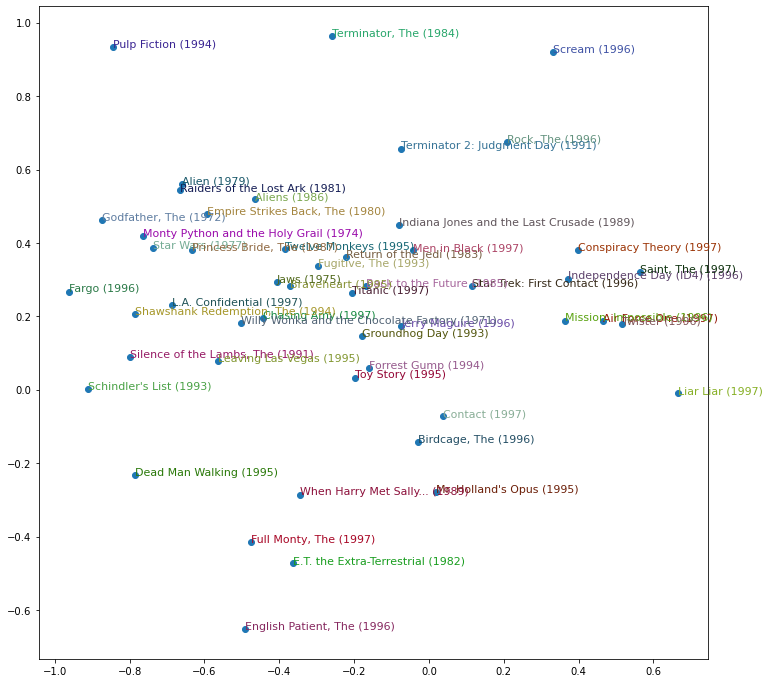

In [137]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=True).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movies_w = learn.model.movie_factors.weight[top_idxs].cpu().detach()
movie_pca = movies_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X,Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i,color=np.random.rand(3)*0.7,fontsize=11)
plt.show()